<B><H2> HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [1]:
import docker
import requests
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation etc.
from scipy import stats

city = 'Melbourne'

2022-08-03 02:08:52.576039: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-03 02:08:52.748133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 02:08:52.748157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [2]:
# Import data from CSV into pandas DF
df= pd.read_csv(f"data/{city}/{city}_area.csv")
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.head()


,Street,Address,Suburb,State,Postcode,Type,Date,Method,Price,Bedrooms,Bathrooms,Cars,Area,Agent,Latitude,Longitude,Distance
0,413/250 Barkly Street,FOOTSCRAY VIC 3011,FOOTSCRAY,VIC,3011,House,22-Jul-22,private treaty,455,2,1,1,0.0,Sweeney Estate Agents Yarraville,-37.798134,144.897345,6.054337
1,28 Moubray Street,ALBERT PARK VIC 3206,ALBERT PARK,VIC,3206,House,27-Nov-21,auction,2270000,2,1,1,0.0,Marshall White Port Phillip,-37.840971,144.951109,3.158503
2,17 Paul Street,CHELTENHAM VIC 3192,CHELTENHAM,VIC,3192,House,26-Nov-21,auction,2260000,4,2,2,0.0,Buxton Real Estate Mentone,-37.961458,145.047628,17.977853
3,2506/83 Queensbridge Street,SOUTHBANK VIC 3006,SOUTHBANK,VIC,3006,Apartment,6-Jan-22,private treaty,2280000,3,3,2,0.0,MICM Real Estate,-37.825362,144.964020,1.241866
4,1/7 Foam Street,HAMPTON VIC 3188,HAMPTON,VIC,3188,House,20-Nov-21,auction,2262000,4,2,2,0.0,Marshall White Port Phillip,-37.937024,145.006746,14.185577


In [3]:
df['Date']= df['Date'].astype('datetime64[ns]')
df['Year'] = df['Date'].dt.year
df.info()


<h5> 1. Define Numeric, Categorical & Features that need to be dropped
<h5> 2. Performing ONE HOT ENCODING on CATEGORICAL features
<h5> 3. Drop unwanted features </h5>




In [4]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:
drop_cat = False

num_feat = ['Bedrooms','Bathrooms','Cars','Area','Latitude','Longitude','Distance','Year']
cat_feat = ['Suburb','Type','Method']
drop_feat = ['Street','Address','State','Postcode','Agent','Date']

# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1)  
df.head()

,Suburb,Type,Method,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Year
0,FOOTSCRAY,House,private treaty,455,2,1,1,0.0,-37.798134,144.897345,6.054337,2022
1,ALBERT PARK,House,auction,2270000,2,1,1,0.0,-37.840971,144.951109,3.158503,2021
2,CHELTENHAM,House,auction,2260000,4,2,2,0.0,-37.961458,145.047628,17.977853,2021
3,SOUTHBANK,Apartment,private treaty,2280000,3,3,2,0.0,-37.825362,144.964020,1.241866,2022
4,HAMPTON,House,auction,2262000,4,2,2,0.0,-37.937024,145.006746,14.185577,2021


<H4> EXPLORATORY DATA ANALYSIS (EDA) </H4>

Explore Relationships between Numerical Features & Price (label)

In [ ]:
sns.pairplot(data = df, y_vars= ['Price'], x_vars = num_feat)

Using Pandas statistics to look for Outliers

Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [5]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  df = df[(np.abs(stats.zscore(df['Price'])) < 3)]
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
  
else:
  remove_outlier(df, num_feat)


Confirm that Outliers have been removed

In [ ]:
df.describe()

In [ ]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

<H4> Plot of Lattitude & longitude showing pricing in each location</H4>
Observe that suburbs closer to the city centre generally are more expensive

In [ ]:
plt.scatter(x = df['Longitude'], y = df['Latitude'],c =df['Price'],alpha=0.8,s=df['Price']/50000,cmap='nipy_spectral' )

Data Splitting into TRAIN,VALIDATION & TEST DF using Scikit Learn function

In [6]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2,random_state=42)
train, val = train_test_split(train, test_size=0.2,random_state=42)

Y_test = test['Price']

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

35857 train examples
8965 validation examples
11206 test examples


In [7]:
# 'get_scal' function takes a list of numerical features and returns a 'minmax' function
# 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number.
# Scalar def get_scal(feature):
# TODO 1d
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [28]:
feature_columns = []

# Numeric columns with Normalization
for header in num_feat:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,normalizer_fn=scal_input_fn))

# Categorical features with One Hot Encoding
Type = fc.categorical_column_with_vocabulary_list('Type', df.Type.unique())
Type_ohe = fc.indicator_column(Type)
feature_columns.append(Type_ohe)

Method = fc.categorical_column_with_vocabulary_list('Method', df.Method.unique())
Method_ohe = fc.indicator_column(Method)
feature_columns.append(Method_ohe)


# Embedding categorical column with MANY unique values
Suburb = fc.categorical_column_with_vocabulary_list('Suburb', df.Suburb.unique())
Suburb_embedded = fc.embedding_column(Suburb, dimension=70)
feature_columns.append(Suburb_embedded)

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Price')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

2022-08-03 02:09:40.188559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-03 02:09:40.188730: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 02:09:40.188773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-MM57QPP): /proc/driver/nvidia/version does not exist
2022-08-03 02:09:40.193665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Defining a normalization/scaling function to be used for numerical features

Normalizing the Training Data,Valuation & test Numerical Features

<h3> Defining & Training a Tensorflow Sequential Regression DNN model.</h3>

In [10]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds, validation_data = val_ds, epochs=20)



1121/1121 [==============================] - 15s 11ms/step - loss: 637960192000.0000 - mse: 637960192000.0000 - val_loss: 426835673088.0000 - val_mse: 426835673088.0000


<h4> Evaluating trained model performance using EVALUATION data </h4>

In [11]:
loss, mse = model.evaluate(val_ds)
print("Mean Squared Error", mse)
print("Root MEAN SQUARE ERROR $",np.sqrt(mse))

281/281 [==============================] - 3s 9ms/step - loss: 426835673088.0000 - mse: 426835673088.0000
Mean Squared Error 426835673088.0
Root MEAN SQUARE ERROR $ 653326.6205260581


<h4> PLOTTING OF LOSS/MSE for TRAINING & EVALUATION DATA  </h4>
Useful to determine underfitting/overfitting as well as optimal number of epcochs for training

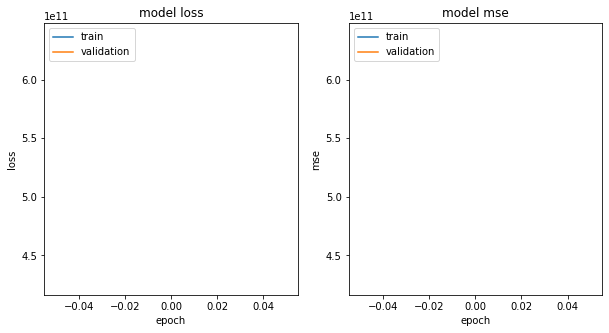

In [12]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

# Plotting
plot_curves(history, ['loss', 'mse'])

<H3> PREDICTION </H3>
<h4>Using TEST data to make PRICE prediction & compare ACTUAL vs PREDICTED</h4>
 

In [46]:
inp = {'Suburb':'BRUNSWICK EAST','Type': 'House','Method': 'auction','Bedrooms':  4, 'Bathrooms':  2, 'Cars':  1, 'Area':  450,'Latitude':  -37.76982778,'Longitude':  144.9784421,'Distance':  5.116915017, 'Year':  2022}
input_df = pd.DataFrame.from_dict(inp)
inp_ds = tf.data.Dataset.from_tensor_slices((dict(input_df)))
inp_ds = inp_ds.batch(1)

pred = model.predict(inp_ds)
print(pred)

Index(['Suburb', 'Type', 'Method', 'Price', 'Bedrooms', 'Bathrooms', 'Cars',
       'Area', 'Latitude', 'Longitude', 'Distance', 'Year'],
      dtype='object')
1/1 [==============================] - 0s 39ms/step
[[1251948.8]]


In [ ]:
predictions = model.predict(test_ds)
print(predictions[1])

#
for i in range(50):
    diff = (predictions[i][0] - test['Price'].iloc[i])/1000
    print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')



plt.scatter(test['Price'].iloc[0:2000],predictions[0:2000])
plt.title("ACTUAL VS PREDICTED PRICE")
plt.xlabel("ACTUAL PRICE: $")
plt.ylabel("PREDICATED PRICE: $")

<h5> SAVE MODEL </h5>

In [ ]:
model.save(f"saved_models/{city}/1")

<h4> SERVE MODEL</h4>
<h5> RUN TF SERVING DOCKER CONTAINER </h5>

In [34]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/MLrealestate:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=real_estate_price_est --model_base_path=/tf_serving/saved_models/',detach = True)

ExecResult(exit_code=0, output=b'bin\nboot\ndev\netc\nhome\nlib\nlib64\nmedia\nmnt\nmodels\nopt\nproc\nroot\nrun\nsbin\nsrv\nsys\ntf_serving\ntmp\nusr\nvar\n')


ExecResult(exit_code=None, output='')

In [ ]:
iterator = examples['train_ds'].__iter__()
next_element = iterator.get_next()
pt = next_element[0]
en = next_element[1]
print(pt.numpy())
print(en.numpy())

In [47]:
input = list(inp.values())
data = {"instances": [inp]}
test.head(5)


,Suburb,Type,Method,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Year
28547,POINT COOK,Townhouse,private treaty,502000,3,2,1,163.0,-37.892656,144.747233,20.874578,2022
9909,AINTREE,House,private treaty,825000,4,2,2,0.0,-37.717471,144.656277,29.050648,2022
24801,MOONEE PONDS,Townhouse,private treaty,1200000,3,3,2,0.0,-37.762071,144.922196,6.827107,2022
9950,IVANHOE,Townhouse,auction,1680000,4,2,2,0.0,-37.766934,145.040037,8.562904,2022
34095,FAWKNER,House,auction,688000,3,1,3,338.0,-37.715212,144.965451,11.014163,2022


<h4> API CALL FOR PREDICTION</h4>
<h5>  REST API POST for LOCAL TF SERVING CONTAINER - MODEL NAME: real_estate_est</h5>

In [49]:
#%%bash
#curl -d '{"instances": [[0.25,0.07553956834532373,0.0,0.25,0.0,0.1937046004842615,0.9103448275862069,0.516068393160683,0.4633053471477789,1.0]]}' \
#-X POST http://localhost:8601/v1/models/melb_price:predict

r = requests.post(url="http://localhost:8601/v1/models/real_estate_price_est:predict", data=json.dumps(data))
print(r.json())

{'predictions': [[1790207.25]]}


In [ ]:
df= pd.read_csv('data/{city}/{city}_area.csv')
#len(df['Suburb'].unique())
df = df.drop_duplicates(subset=['Suburb','Type','Method'], keep='last')
df.to_csv('data/{city}/{city}_template.csv',index = False)
df.info()
#df.head(20)

In [ ]:
%%bash
heroku container:login
heroku container:push web -a tf-serve-model
heroku container:release web -a tf-serve-model
heroku logs -a tf-serve-model --tail